# Heating oil delivery

A transporter has to deliver heating oil from the refinery at California to a certain number of clients in the US. His clients are located at California, Washington, Nueva York, Colorado, Texas, Tennessee, Dakota. The demands in liters for the different sites and distance between clients and the refinery are known. The transport company uses tankers with a capacity of 39000 liters for the deliveries. Determine the tours for delivering to all clients that minimize the total number of kilometers driven.

### Mathematical Programming Model
#### Sets:
- $I$: Locations (Refinery + Clients).
- $J$: Clients.

#### Inputs:
- $c_{ij}$: Distance between client $i$ and $j$.
- $d_{i}$: Demand of client $i$.
- $w$: Tank capacity in liters.

#### Decision Variables:
- $x_{ij}$: 1 if client $j$ is visited immediately after client $i$.
- $y_{i}$: Quantity of oil delivered up to $i$.

#### Objective Function: Minimize the total kilometers driven.
$$\text{min} \sum_{i \in I} \sum_{j \in I, i \neq j} c_{ij}x_{ij}$$

#### Constraints:
1. Client $j$ could be visited only by one $i$ location.
$$\sum_{i \in I, i \neq j} x_{ij} = 1 \qquad \forall j \in J$$

2. Client $i$ could visit only one $j$ location.
$$\sum_{j \in I, i \neq j} x_{ij} = 1 \qquad \forall i \in J$$

3. The quantity of oil delivered must be at least as large as the quantity ordered by client $i$.
$$d_{i} \leq y_{i} \qquad \forall i \in J$$

4. The quantity of oil delivered to client $i$ must be less than tank capacity.
$$y_{i} \leq w \qquad \forall i \in J$$

5. If client $i$ is the first of a tour, then $y_{i}$ is equal to the quantity ordered by this client. Otherwise, it could be at least as large as the tank capacity.
$$y_{i} \leq w + (d_{i} - w)x_{1i} \qquad \forall i \in J$$

6. If client $i$ is the first of a tour, then $y_{i}$ is equal to the quantity delivered from the refinery up to client $i$ plus the quantity ordered by client $j$.
$$y_{j} \geq y_{i} + d_{j} - w + w x_{ij} + (w - d_{j} - d_{i})x_{ji} \qquad \forall i,j \in J, i \neq j$$

7. Quantity of oil delivered is non-negative.
$$y_{i} \geq 0 \qquad \forall i \in J$$

8. Tour decision is binary.
$$x_{ij} \in \{0,1\} \qquad \forall i,j \in I, i \neq j$$

In [23]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = pd.read_excel("./data/heating_oil_delivery.xlsx", sheet_name=None)
data

{'Distances':           i\j  California  Washington  Nueva York  Colorado  Texas  Tennessee  \
 0  California           0         148          55        32     70        140   
 1  Washington         148           0          93       180     99         12   
 2  Nueva York          55          93           0        85     20         83   
 3    Colorado          32         180          85         0    100        174   
 4       Texas          70          99          20       100      0         85   
 5   Tennessee         140          12          83       174     85          0   
 6      Dakota          73          72          28        99     49         73   
 
    Dakota  
 0      73  
 1      72  
 2      28  
 3      99  
 4      49  
 5      73  
 6       0  ,
 'Demand':        Client  Demand  Tank_capacity
 0  Washington   14000        39000.0
 1  Nueva York    3000            NaN
 2    Colorado    6000            NaN
 3       Texas   16000            NaN
 4   Tennessee   15000  

In [14]:
distances = data["Distances"]
distances.index = distances.iloc[:,0]
distances = distances.drop(columns=distances.columns[0])
distances

,California,Washington,Nueva York,Colorado,Texas,Tennessee,Dakota
i\j,,,,,,,
California,0,148,55,32,70,140,73
Washington,148,0,93,180,99,12,72
Nueva York,55,93,0,85,20,83,28
Colorado,32,180,85,0,100,174,99
Texas,70,99,20,100,0,85,49
Tennessee,140,12,83,174,85,0,73
Dakota,73,72,28,99,49,73,0


In [16]:
demand = data["Demand"]
demand.index = demand["Client"]
demand = demand.drop(columns=["Client"]).copy()
demand

,Demand,Tank_capacity
Client,,
Washington,14000,39000.0
Nueva York,3000,NaN
Colorado,6000,NaN
Texas,16000,NaN
Tennessee,15000,NaN
Dakota,5000,NaN


In [17]:
# Set of Locations
I = distances.index

# Set of Clients
J = I[1:]

# Demand
d = demand["Demand"]

# Tank capacity in liters
w = demand["Tank_capacity"].values[0]

In [18]:
model = pyo.ConcreteModel("Heating oil delivery")

model.x = pyo.Var(I, I, domain=pyo.Binary, doc="1 if client j is visited immediately after client i")
model.y = pyo.Var(I, domain=pyo.NonNegativeReals, doc="Quantity of oil delivered up to i")

model.objective = pyo.Objective(expr=sum(distances.loc[i,j]*model.x[i,j] for i in I for j in I if i != j), doc="Minimize the total kilometers driven")

model.constraint1 = pyo.ConstraintList(doc="Client j could be visited only by one i location")
for j in J:
    model.constraint1.add(expr=sum(model.x[i,j] for i in I if i != j) == 1)

model.constraint2 = pyo.ConstraintList(doc="Client i could visit only one j location")
for i in J:
    model.constraint2.add(expr=sum(model.x[i,j] for j in I if i != j) == 1)

model.constraint3 = pyo.ConstraintList(doc="The quantity of oil delivered must be at least as large as the quantity ordered by client i")
for i in J:
    model.constraint3.add(expr=model.y[i] >= d[i])

model.constraint4 = pyo.ConstraintList(doc="The quantity of oil delivered to client i must be less than tank capacity")
for i in J:
    model.constraint4.add(expr=model.y[i] <= w)

model.constraint5 = pyo.ConstraintList(doc="If client i is the first of a tour, then y[i] is equal to the quantity ordered by this client.\
                                       Otherwise, it could be at least as large as the tank capacity")
for i in J:
    model.constraint5.add(expr=model.y[i] <= w + (d[i] - w)*model.x[I[0], i])

model.constraint6 = pyo.ConstraintList(doc="If client i is the first of a tourm then y[i] is equal to the quantity delivered from refinery\
                                       up to client i plus the quantity ordered by client j")
for i in J:
    for j in J:
        if i != j:
            model.constraint6.add(expr=model.y[j] >= model.y[i] + (d[j] - w) + w*model.x[i,j] +\
                                                                                        (w - d[j] - d[i])*model.x[j,i])

solver = pyo.SolverFactory("glpk")
results = solver.solve(model)
results

{'Problem': [{'Name': 'unknown', 'Lower bound': 497.0, 'Upper bound': 497.0, 'Number of objectives': 1, 'Number of constraints': 60, 'Number of variables': 48, 'Number of nonzeros': 216, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '161', 'Number of created subproblems': '161'}}, 'Error rc': 0, 'Time': 0.018558979034423828}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [19]:
model.pprint()

2 Var Declarations
    x : 1 if client j is visited immediately after client i
        Size=49, Index={Texas, California, Dakota, Nueva York, Colorado, Washington, Tennessee}*{Texas, California, Dakota, Nueva York, Colorado, Washington, Tennessee}
        Key                          : Lower : Value : Upper : Fixed : Stale : Domain
        ('California', 'California') :     0 :  None :     1 : False :  True : Binary
          ('California', 'Colorado') :     0 :   1.0 :     1 : False : False : Binary
            ('California', 'Dakota') :     0 :   1.0 :     1 : False : False : Binary
        ('California', 'Nueva York') :     0 :   0.0 :     1 : False : False : Binary
         ('California', 'Tennessee') :     0 :   0.0 :     1 : False : False : Binary
             ('California', 'Texas') :     0 :   0.0 :     1 : False : False : Binary
        ('California', 'Washington') :     0 :   0.0 :     1 : False : False : Binary
          ('Colorado', 'California') :     0 :   0.0 :     1 : F

In [55]:
for i in I:
    for j in J:
        if i != j and pyo.value(model.x[i,j]) != 0:
            oil = pyo.value(model.y[j])
            print(f"Goes to client in {j} after visit client in {i} and is delivering {oil} oil liters")

Goes to client in Colorado after visit client in California and is delivering 6000.0 oil liters
Goes to client in Dakota after visit client in California and is delivering 5000.0 oil liters
Goes to client in Tennessee after visit client in Washington and is delivering 34000.0 oil liters
Goes to client in Texas after visit client in Colorado and is delivering 22000.0 oil liters
Goes to client in Nueva York after visit client in Tennessee and is delivering 37000.0 oil liters
Goes to client in Washington after visit client in Dakota and is delivering 19000.0 oil liters


In [22]:
print(f"Distance traveled: {pyo.value(model.objective)}km")

Distance traveled: 497.0km


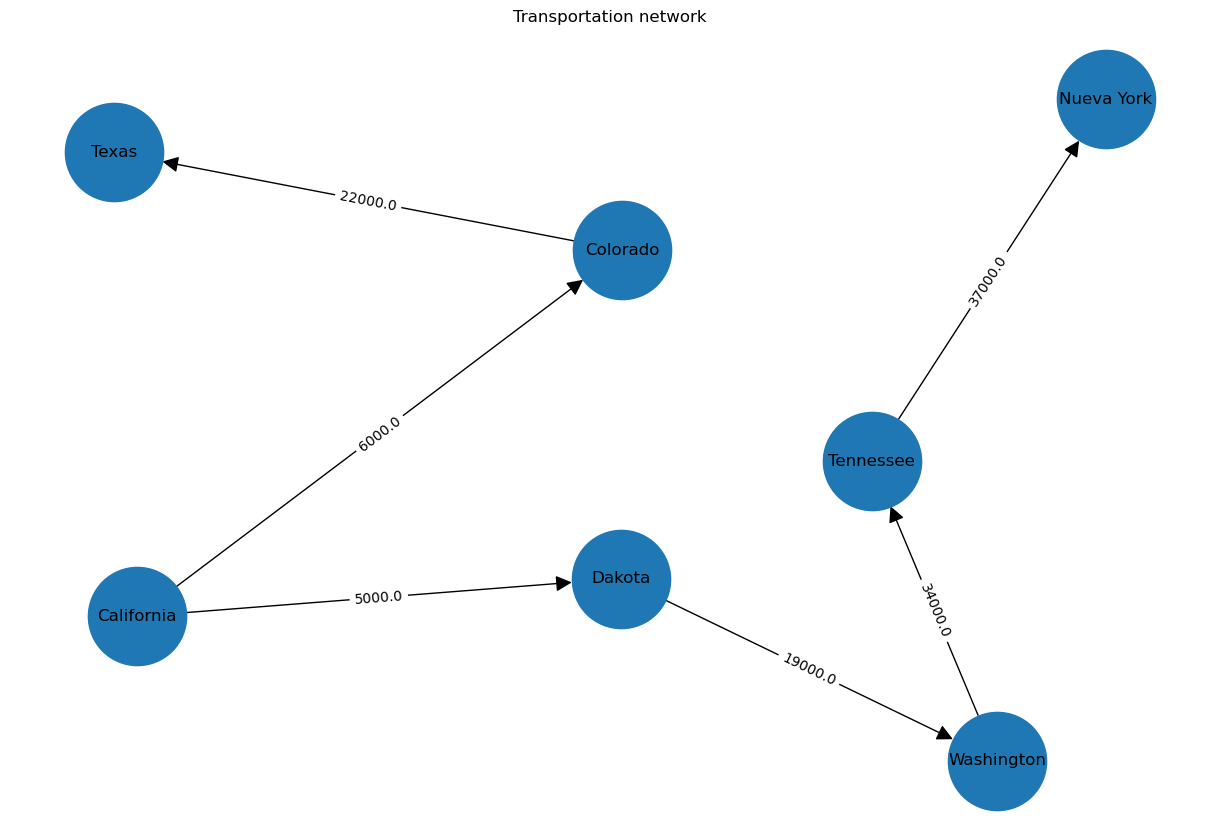

In [80]:
# Let's plot the solution as a network
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

for source in I:
    for destination in J:
        if source != destination and pyo.value(model.x[source, destination]) != 0:
            oil = pyo.value(model.y[destination])
            G.add_edge(source, destination, weight=oil)

# Positioning the nodes
pos = nx.spring_layout(G, k=30, iterations=50)
edge_labels = nx.get_edge_attributes(G, "weight")

options = {
    "node_size": 5000,
    "arrowsize": 24
}

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, arrows=True, **options)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Transportation network")
plt.show()